In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_column', 100)

In [4]:
print("\\")

\


In [2]:
raw_path = '/Users/zihaoxu/R_repos/sgv_bike/datasets/raw/'
mst_path = '/Users/zihaoxu/R_repos/sgv_bike/datasets/mst/'

In [3]:
################## Helper funcs ##################

# Fill columns with the class mode
def fill_w_mode(df, col):
    mode = df[col].value_counts().index[0]
    print("Mode for "+col+":", mode)
    df[col] = df[col].fillna(mode)
    return df

# For other_var1 and other_var2
def clean_entry(df, col):
    df[col] = df[col].str.lower()
    df[col] = df[col].str.strip()
    df[col] = df[col].str.replace(" - ", "_")
    df[col] = df[col].str.replace("0", "none")
    df[col] = df[col].str.replace(" ", "_")
    return df

In [4]:
################## Load in the data set ##################  
df = pd.read_csv(raw_path + 'bike.csv')
df.index = range(len(df))
df.shape

(2624, 35)

In [5]:
################## Fixing columns with NaNs ################## 
print('Number of cols with nan:', np.sum(df.isnull().sum() != 0))

# Fill with class mode for landuse, road_class
df = fill_w_mode(df, 'landuse')
df = fill_w_mode(df, 'road_class')

# Fill with 'none' for unusual, bikewaytype_options, other_var2, landuse
for col in ['unusual', 'bikewaytype_options', 'street1', 'street2', 'street3', 'other_var1', 'other_var2']:
    df[col] = df[col].fillna('none')
    
# Fill with 0 for count_bikesonsidewalks
df['count_bikesonsidewalks'] = df['count_bikesonsidewalks'].fillna(0)
print('Number of cols with nan:', np.sum(df.isnull().sum() != 0))

Number of cols with nan: 22
Mode for landuse: residentialCommercial
Mode for road_class: minorArterial
Number of cols with nan: 14


ns <= totol_count:  True
sn <= totol_count:  True
ew <= totol_count:  True
we <= totol_count:  True
female <= totol_count:  True
sidewalk <= totol_count:  True
wrongway <= totol_count:  True


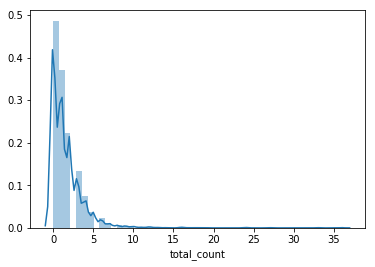

In [6]:
################## Create new columns ################## 
# total_count: total number of bike riders
df['total_count'] = [a+b+c+d for a,b,c,d in zip(df['ns'], df['sn'], df['ew'], df['we'])]

# Correct for human errors
# df['total_count'] = [max(a,b,c,d) for a,b,c,d in zip(df['total_count'], df['female'], df['sidewalk'], df['wrongway'])]

# Sanity check, total_cuont is the largetest among all count columns
count_cols = ['ns', 'sn', 'ew', 'we', 'female', 'sidewalk', 'wrongway']
for col in count_cols:
    print(col + " <= totol_count: ", len(df[df['total_count'] < df[col]]) == 0)
sns.distplot(df['total_count'])

In [7]:
# Clean entries of other_var1 and other_var2
df = clean_entry(df, 'other_var1')
df = clean_entry(df, 'other_var2')

# Print our the distinct values and counts
print(df['other_var1'].value_counts())
print(df['other_var2'].value_counts())

no_helmet    2576
none           32
child          16
Name: other_var1, dtype: int64
child        2264
none          296
children       48
no_helmet      16
Name: other_var2, dtype: int64


In [8]:
# We see that we need to create  new variables: no_helmet, child, sidewald_riding, wrong_way_riding
df['no_helmet'] = np.where(df['other_var1'] == 'no_helmet', df['other_var1_count'], 0)
df['no_helmet'] = np.where(df['other_var2'] == 'no_helmet', df['other_var2_count'], df['no_helmet'])
df['child'] = np.where(df['other_var1'] == 'child', df['other_var1_count'], 0)
df['child'] = np.where((df['other_var2'] == 'child') | (df['other_var2'] == 'children'), df['other_var2_count'], df['child'])
df['sidewalk_riding'] = np.where(df['other_var1'] == 'sidewalk_riding', df['other_var1_count'], 0)
df['wrong_way_riding'] = np.where(df['other_var1'] == 'wrong_way_riding', df['other_var1_count'], 0)
df['wrong_way_riding'] = np.where(df['other_var2'] == 'wrong_way_riding', df['other_var2_count'], df['wrong_way_riding'])


def find_num_replace(df, other_var_name, starting_str, nums):
    for num in nums:
        df[starting_str] = np.where(df[other_var_name] == starting_str + "_" + str(num), num, df[starting_str])
    return df
                                
# Fix bad naming for other_var1 and other_var2
df = find_num_replace(df, 'other_var1', 'wrong_way_riding', [1])
df = find_num_replace(df, 'other_var1', 'female', [1,3])
df = find_num_replace(df, 'other_var1', 'sidewalk_riding', [4])
df = find_num_replace(df, 'other_var2', 'no_helmet', [5,4,3])

In [9]:
# Cols sidewalk and wrongway exists in the dataset, so we should combine the columns
df['wrongway'] = np.where(df['wrongway'] == 0, df['wrong_way_riding'], df['wrongway'])
df['sidewalk'] = np.where(df['sidewalk'] == 0, df['sidewalk_riding'], df['sidewalk'])

In [10]:
# Sanity check
df[['no_helmet', 'child', 'wrong_way_riding', 'sidewalk_riding', 'other_var1', 'other_var1_count', 'other_var2', 'other_var2_count']].head(5)

,no_helmet,child,wrong_way_riding,sidewalk_riding,other_var1,other_var1_count,other_var2,other_var2_count
0,1,0,0,0,no_helmet,1,child,0
1,0,0,0,0,no_helmet,0,child,0
2,0,0,0,0,no_helmet,0,child,0
3,0,0,0,0,no_helmet,0,child,0
4,0,0,0,0,no_helmet,0,child,0


In [11]:
# Drop 'other_var1', 'other_var1_count', 'other_var2', 'other_var2_count'
df = df.drop(['other_var1', 'other_var1_count', 'other_var2', 'other_var2_count', 'sidewalk_riding', 'wrong_way_riding'], 1)

In [12]:
# Fix issues with count_bikesonsidewalks
df['count_bikesonsidewalks'] = np.where((df['count_bikesonsidewalks'] == 'No') | (df['count_bikesonsidewalks'] == '0'),\
                                        0, df['count_bikesonsidewalks'])
df['count_bikesonsidewalks'] = np.where(df['count_bikesonsidewalks'] == 'Yes', 1, df['count_bikesonsidewalks'])

In [13]:
# Create column city
df['dataset_name'] = df['dataset_name'].str.replace('BikeSGV ', '')
df['dataset_name'] = df['dataset_name'].str.replace('Bike SGV ', '')
df['dataset_name'] = df['dataset_name'].str.replace('BikeSGv ', '') 
df['dataset_name'] = df['dataset_name'].str.replace(' 2016', '')
df['dataset_name'] = df['dataset_name'].str.replace(' 2017', '')
df = df.rename(columns = {'dataset_name' : 'city'})

In [14]:
# Sanity check, total_cuont is the largetest among all count columns
num_cols = ['ns', 'sn', 'ew', 'we', 'female', 'sidewalk', 'wrongway']
for col in num_cols:
    print(col + " <= totol_count: ", len(df[df['total_count'] < df[col]]) == 0)

ns <= totol_count:  True
sn <= totol_count:  True
ew <= totol_count:  True
we <= totol_count:  True
female <= totol_count:  True
sidewalk <= totol_count:  True
wrongway <= totol_count:  True


In [15]:
df.head()

,intervalid,location_id,street1,street2,street3,latitude,longitude,date,weekday,period_begin,period_end,interval_begin,ns,sn,ew,we,female,sidewalk,wrongway,count_method,count_bikesonsidewalks,raining,unusual,bikewaytype,bikewaytype_options,road_class,speed_limit,landuse,pk_dataset_id,city,createdatetime,total_count,no_helmet,child
0,19203.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,11:00 AM,0,0,0,1,0,0,1.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,1,1,0
1,19204.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,11:15 AM,0,0,1,0,0,0,0.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,1,0,0
2,19205.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,11:30 AM,0,0,1,0,0,0,0.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,1,0,0
3,19206.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,11:45 AM,0,0,2,0,0,0,0.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,2,0,0
4,19207.0,1025.0,Durfee Ave.,Santa Anita Ave.,Peck Rd.,34.035943,-118.039993,12-03-2016,Saturday,11:00 AM,1:00 AM,12:00 PM,0,0,0,0,0,0,0.0,manual_in_house,1,no,none,none,none,minorArterial,40.0,neighborhoodRetail,133.0,SEM,2017-07-17 15:08:00,0,0,0


In [16]:
df.to_csv(mst_path + 'clean_bike.csv', index = None)